In [2]:
import torch 
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

### 1. let's make train and test data 

In [3]:
# get the training and test data 
train_data = datasets.FashionMNIST(root='DATA',train=True,download=True,transform=ToTensor(),target_transform=None)
test_data = datasets.FashionMNIST(root='DATA',train=False, download=True,transform=ToTensor())

In [4]:
# let's see what is inside the first element 
image,label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [5]:
# how many train/test samples ? 
len(train_data.data),len(train_data.targets),len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [6]:
# classes 
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### 2. Visualize data (and explore data)

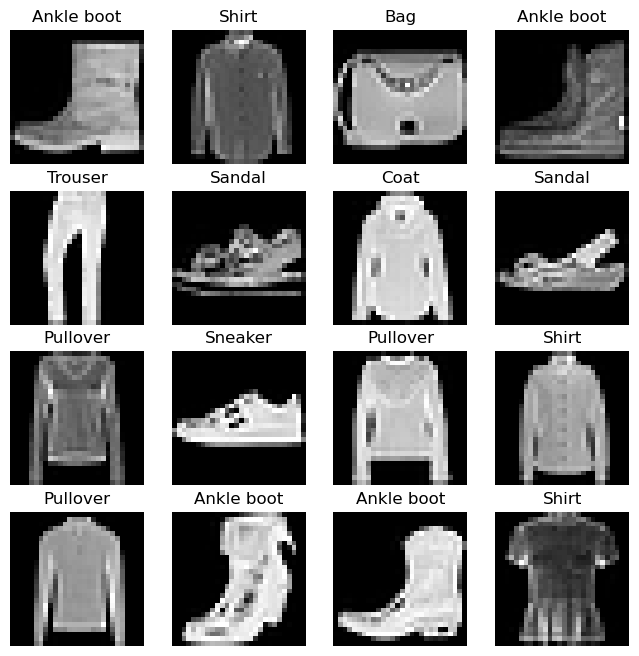

In [7]:
# plot few images 

torch.manual_seed(42)
fig = plt.figure(figsize=(8,8))
rows, cols = 4, 4 
for i in range(1, rows*cols +1 ):
    random_idx = torch.randint(0,len(train_data),size=(1,)).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.title(train_data.classes[label])
    plt.axis(False)

### 3. Make data loaders

In [8]:
batch_size = 32 

# these are iterables 
train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

# length of data loader = len(data)/batch_size
len(train_dataloader), len(test_dataloader)

(1875, 313)

### 4. Build the model 

In [9]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units), 
            nn.Linear(in_features=hidden_units, out_features=output_shape))
    
    def forward(self, x):
        return self.layer_stack(x)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class_names = train_data.classes
model_0 = FashionMNISTModelV0(input_shape=784,hidden_units=10,output_shape=len(class_names))

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### 4.2 Loss function/ optimization

In [11]:
# accuracy function 
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

# loss function 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),lr=0.1)


### 4.3 Training loop

In [12]:
epochs = 3 

for epoch in range(epochs):
    print(f'Epoch : {epoch}')
    ### Training 
    train_loss = 0 
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        # 1. forward pass 
        y_pred = model_0(X)
        
        # 2. get the loss 
        loss = loss_fn(y_pred,y)
        train_loss += loss
        
        # 3. optimizer zero grad 
        optimizer.zero_grad()
        
        # 4. loss backward 
        loss.backward()
        
        # 5. optimizer step 
        optimizer.step()
        
        if batch % 400 == 0:
            print(f'Looked at {batch *len(X)}/{len(train_dataloader.dataset)}')
            
    # avg loss over data set
    train_loss/=len(train_dataloader)
    
    ### Testing 
    test_loss,test_acc = 0,0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. forward pass 
            test_pred = model_0(X)
            
            # 2. find the losses (per batch and add)
            test_loss += loss_fn(test_pred,y)
            test_acc  += accuracy_fn(y, test_pred.argmax(dim=1))
         
        # avg loss over whole data set    
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
    # print 
    print(f'Train Loss:{train_loss:.5f} | Test Loss:{test_loss:.5f} | Test Accuracy:{test_acc:.2f}')

Epoch : 0
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
Train Loss:0.59295 | Test Loss:0.49324 | Test Accuracy:82.60
Epoch : 1
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
Train Loss:0.47485 | Test Loss:0.49931 | Test Accuracy:82.90
Epoch : 2
Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000
Train Loss:0.45464 | Test Loss:0.48230 | Test Accuracy:83.41


### Model 2 with ReLU() non-linearity 

In [13]:
# model 2
class FashionMNISTModelV1(nn.Module):
    def __init__(self,input_shape,hidden_units,out_shape):
        super().__init__()
        self.layer_stack_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=out_shape))
        
    def forward(self,x):
        return self.layer_stack_1(x)
        
model_1 = FashionMNISTModelV1(input_shape=784,hidden_units=10,out_shape=10)
model_1

FashionMNISTModelV1(
  (layer_stack_1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [14]:
# loss fucntion and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=0.1)

In [18]:
# let's write 2 seperate functions for train and test 

import torch.utils
import torch.utils.data

# train function 
def train_step(model, data_loader, loss_fn, optimizer,accuracy_fn, device):
    train_loss, train_acc = 0, 0 
    model.to(device)
    
    for batch, (X,y) in enumerate(data_loader):
        X,y = X.to(device),y.to(device) # send data to GPU 
        y_pred = model(X)               # forward pass 
        # losses 
        loss = loss_fn(y_pred,y)
        train_loss += loss 
        train_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss/=len(data_loader)
    train_acc/=len(data_loader)
    
    print(f'Train loss:{train_loss:.5f} | Train accuracy:{train_acc:.2f} %')
    
        
# test function 
def test_step(model,data_loader,loss_fn,accuracy_fn,device):
    test_loss, test_acc = 0,0 
    model.to(device)
    model.eval()
    
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred,y)
            test_acc += accuracy_fn(y,test_pred.argmax(dim=1))
            
        test_loss /= len(data_loader)
        test_acc/= len(data_loader)
    
        print(f'Test loss:{test_loss:.5f} | Test acc : {test_acc:.2f} %')
        

In [19]:
# training loop 

epochs = 3 
for epcoh in range(epochs):
    print(f'Epoch : {epoch} \n..............')
    # train 
    train_step(model=model_1,data_loader=train_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,optimizer=optimizer,device=device)
    # test 
    test_step(model=model_1,data_loader=train_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,device=device)

Epoch : 2 
..............
Train loss:0.50319 | Train accuracy:82.10 %
Test loss:0.45957 | Test acc : 83.52 %
Epoch : 2 
..............
Train loss:0.47082 | Train accuracy:83.03 %
Test loss:0.44212 | Test acc : 83.86 %
Epoch : 2 
..............
Train loss:0.45536 | Train accuracy:83.48 %
Test loss:0.43064 | Test acc : 84.42 %
